### Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
# Computational packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
plt.style.use('../bioAI.mplstyle')

# General packages
import datetime
import sys
import os

# custom packages
import ratsimulator
from ratsimulator.Environment import Rectangle
import spatial_maps as sm # CINPLA spatial maps

# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None 
from PlaceCells import PlaceCells
from Models import SorscherRNN
from Experiment import Experiment
from methods import *
from datahandling import *
from Plots import *

### Setup Experiment

In [9]:
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name := 'gg-default', base_path = base_path)
experiment.setup()

Experiment <gg-defalt> is NEW. Loading DEFAULT experiment settings!
Singular matrix
Singular matrix
Default <params>, <environments>, <agents> and <pc_ensembles> can now be changed. Finish setup by calling setup()
Creating directories
Saving experiment details


True

In [10]:
checkpoint_filenames = filenames(experiment.paths['checkpoints'])
# load model latest (wrt. #epochs trained)
print(f"Loading model at epoch = {checkpoint_filenames[-1]}")
checkpoint = torch.load(experiment.paths['checkpoints'] / checkpoint_filenames[-1])
with open(experiment.paths["experiment"] / "logger.pkl", "rb") as f:
    logger = pickle.load(f)

IndexError: list index out of range

### Helper functions

In [11]:
def metric_fraction_to_checkpoint(metric, ps=[0.9999, 0.95, 0.05]):
    # find training phases as a fraction of loss-differences
    metric = np.array(metric)
    metric_diff = np.max(metric) - np.min(metric)
    metric_phases = metric_diff * np.array(ps)
    metric_phases += np.min(metric)
    metric_phase_idxs = abs(metric_phases[:, None] - metric[None])  # shape: (3, #epochs)
    metric_phase_idxs = np.argmin(metric_phase_idxs, axis=-1)  # shape: (3,)

    # find closest (rounded) model checkpoints to the phase idxs
    checkpoint_filenames = filenames(experiment.paths["checkpoints"])
    checkpoint_nums = [
        int(checkpoint_filename) for checkpoint_filename in checkpoint_filenames
    ]
    save_freq = checkpoint_nums[2] - checkpoint_nums[1]
    checkpoint_phase_nums = baround(metric_phase_idxs, save_freq)
    checkpoint_phase_nums = np.minimum(checkpoint_phase_nums, np.max(checkpoint_nums))
    checkpoint_phase_filenames = [
        f"{checkpoint_phase_num:05d}.pkl"
        for checkpoint_phase_num in checkpoint_phase_nums
    ]
    return checkpoint_phase_filenames

def load_grid_scores():
    # load grid scores for environments
    sorted_scores = []
    sort_idxs = []
    for grid_score_filename in filenames(experiment.paths["grid_scores"]):
        with open(experiment.paths["grid_scores"] / grid_score_filename, "rb") as f:
            score_map = pickle.load(f)

        sort_idxs.append(np.argsort(score_map)[::-1])
        sorted_scores.append(score_map[sort_idxs[-1]])
    return sort_idxs, sorted_scores

checkpoint_phase_filenames = metric_fraction_to_checkpoint(logger.training_metrics['familiar']['KL'])
sort_idxs, sorted_scores = load_grid_scores()

IndexError: list index out of range

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/WD12TB-HDD/data/emergent-grid-cells/gg-defalt/ratemaps/env_0/00050.pkl'

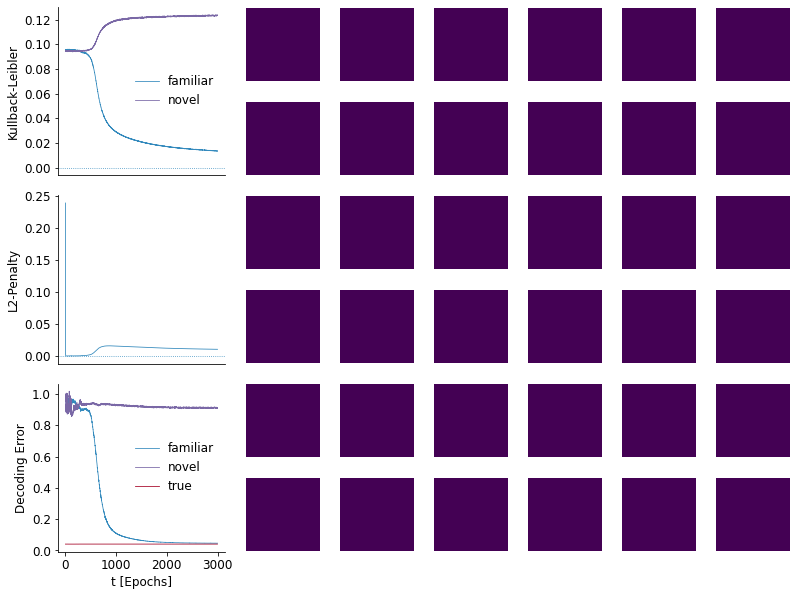

In [12]:
"""
CREATE PANE LAYOUT
"""
figdims = np.array([6,8])
scale = 1.4

figsize = figdims[::-1] * scale # figsize is width by height, subplots is height by width
fig = plt.figure(figsize=figsize)
lh_ax = plt.subplot2grid(figdims, (0,0), colspan=2, rowspan=2, fig=fig)
l2_ax = plt.subplot2grid(figdims, (2,0), colspan=2, rowspan=2, fig=fig)
de_ax = plt.subplot2grid(figdims, (4,0), colspan=2, rowspan=2, fig=fig)
axs = np.zeros((6,6),dtype='object')
for i in range(6):
    for j in range(6):
        axs[i,j] = plt.subplot2grid(figdims, (i,2+j), colspan=1, rowspan=1, fig=fig)
        axs[i,j].axis('off')
        axs[i,j].imshow(np.zeros((10,10)))
        
        
"""
POPULATE TRAINING DYNAMICS
"""
lh_ax.plot(logger.training_metrics['familiar']['KL'],label='familiar')
lh_ax.plot(logger.training_metrics['novel']['KL'],label='novel')
lh_ax.legend()
lh_ax.axhline(0,ls=":")
lh_ax.set_ylabel('Kullback-Leibler')
lh_ax.xaxis.set_visible(False)

l2_ax.plot(logger.training_metrics['familiar']['l2_reg'])
l2_ax.axhline(0,ls=":")
l2_ax.set_ylabel('L2-Penalty')
l2_ax.xaxis.set_visible(False)

de_ax.plot(logger.training_metrics['familiar']['pred_error'],label='familiar')
de_ax.plot(logger.training_metrics['novel']['pred_error'],label='novel')
de_ax.plot(logger.training_metrics['familiar']['true_error'],label='true')
de_ax.legend()
de_ax.set_ylabel('Decoding Error')
de_ax.set_xlabel('t [Epochs]')


"""
POPULATE RATEMAPS
"""
# load ratemaps for environment
ratemaps = []
selected_sorted_cells = [2, 15, 2048, 4095]
for j, checkpoint_phase_filename in enumerate(checkpoint_phase_filenames):
    for env_i in range(len(experiment.environments)):
        ratemap_filename = (
            experiment.paths["ratemaps"]
            / f"env_{env_i}"
            / checkpoint_phase_filename
        )
        with open(ratemap_filename, "rb") as f:
            ratemaps_i = pickle.load(f)

        for ratemap_example_k in range(num_ratemap_examples := 4):
            ratemap_idx = sort_idxs[env_i][selected_sorted_cells[ratemap_example_k]]
            ratemap_score = np.around(
                sorted_scores[env_i][selected_sorted_cells[ratemap_example_k]],
                decimals=2,
            )
            ratemap = ratemaps_i[ratemap_idx]
            ax = axs[j*2 + (ratemap_example_k//2), env_i*2 + (ratemap_example_k%2)]
            ax.imshow(ratemap)
            if j == 0:
                ax.set_title(f"id={ratemap_idx}")
            elif j == len(checkpoint_phase_filenames) - 1:
                ax.set_title(f"gcs={ratemap_score}")

In [ ]:
fig.savefig(experiment.paths['experiment'] / (figname))